# Scoring methods in Credit Risk

**Author: Bartłomiej Jamiołkowski** <br>
**Subject: Credit and operational risk modeling** <br>
**Major: Computer Science and Econometrics** <br>
**Date: April 15, 2022**

## 1. Introduction

This project aims to introduce the reader to the scoring methods in credit risk by presenting the substantive content supported by examples. For this reason, the first part of the work focuses on discussing the theoretical aspects of scoring. The next stage is the preparation and analysis of the selected data set, which will be used to demonstrate the operation of selected scoring methods. Ultimately, the project provides for an evaluation of the results completed with a summary.
The project is implemented using the Python language in Jupyter Notebook.

### 1.1 Credit Scoring definition

Credit Scoring is a statistical method that is used to predict the probability that credit applicants or existing borrowers will default or turn out to be criminals. On their basis, a numerical assessment of creditworthiness is issued. The higher the value, the smaller the probability of a given person's arrears with repayment of loan installments.

### 1.2 Use cases

In practice, credit scoring is most often used in the case of: consumer loans, credit cards and mortgage loans. This includes various processes:
1. creditworthiness assessment;
2. analysis of behavioral information showing how a given person may behave during the loan term, eg how regularly he repays it and what his expenses are under the contract;
3. Another important aspect is the provision of information on events that may affect the borrower's credit risk;
4. An interesting application of scoring models is the detection of suspicious activities of persons applying for credit that appear to be fraudulent.

## 2. Data in the project
The project dataset was taken from [Kaggle: Your Machine Learning and Data Science Community] (https://www.kaggle.com/datasets/dansbecker/aer-credit-card-data). It comes from the book "Econometric Analysis" by William H. Greene. It consists of 1,319 observations covering the demographic data and credit history of applicants for a new loan. <br>
It should be understood that data acquisition is necessary to: assess borrowers, evaluate and develop scoring models.

### 2.1 Libraries used
The project uses libraries for: data collection, processing, visualization and implementation of selected credit scoring methods.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.svm import SVC
import sklearn.metrics as metrics

### 2.2 Data import

In [2]:
credit_card = pd.read_csv('AER_credit_card_data.csv')

In [3]:
credit_card.head(4)

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.52,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.42,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.50,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.54,0.065214,137.869200,no,no,0,25,1,7


### 2.3 Description of variables
In the study, the explained variable is the card variable, while the other variables explain it. The meaning of individual variables is as follows:
- card: dummy variable, 1 if the credit card application is successful, 0 if not;
- reports: number of negative reports that are the result of delays in loan repayment;
- age: age n plus the twelfths of the year;
- income: annual income (divided by 10,000 dollars);
- share: the ratio of monthly credit card expenses to annual income;
- exenditure: average monthly credit card expenses;
- owner: 1 if he owns the house, 0 if he is renting it;
- selfemp: 1 if self-employed, 0 if not;
- dependents: 1 + number of dependents;
- months: number of months of residence at the current address;
- majorcards: number of major credit cards held;
- active: number of active credit accounts.

### 2.4 Convert raw data set
First of all, it is necessary to examine what type of particular variables have to avoid further problems with data processing. The dataset will then be searched for missing or outlier values that need to be replaced or removed.

In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   object 
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


The printout shows what types each variable has. It can be seen that some of them need to be converted into values, for example
integers, because in their current state they cannot be used in modeling.

In [5]:
credit_card["card"] = np.where(credit_card["card"] == "yes", 1, 0)
credit_card["owner"] = np.where(credit_card["owner"] == "yes", 1, 0)
credit_card["selfemp"] = np.where(credit_card["selfemp"] == "yes", 1, 0)

#### 2.4.1 Working with Missing Values
Missing values are often inherent in downloaded datasets. The most common examples of their occurrence in the area of credit risk are:
1. optional fields to be completed in the questionnaires;
2. the field in the questionnaire may not be applicable to all customers;
3. the information has not been collected before the specified time has elapsed;
4. some information was not provided due to the lack of proper contact with the client or his inability to answer specific questions.

In [6]:
credit_card.isna().sum(axis = 0)

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

The printout indicates that there are no missing values in this book dataset.
#### 2.4.2 Detection and removal of outliers
The next step is to look for outliers, i.e. values that are significantly distant from most observations.
There are a number of methods used for this purpose. The use of box plots is preferred in the project.

<AxesSubplot:xlabel='card', ylabel='months'>

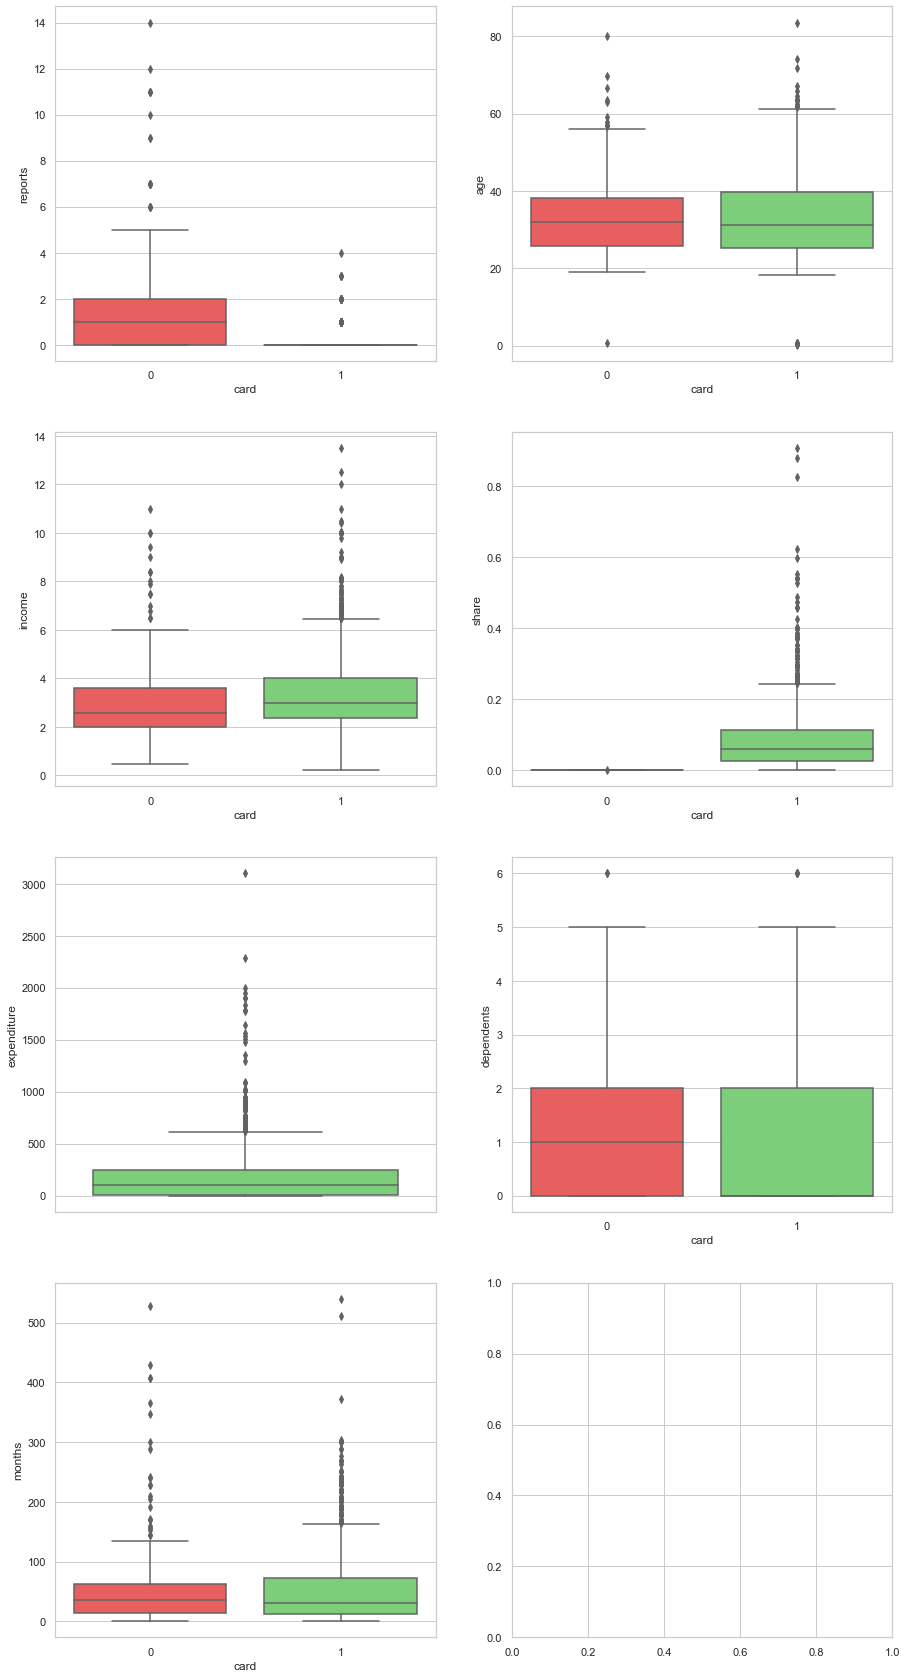

In [7]:
sns.set(rc={'figure.figsize':(15, 30)})
sns.set_theme(style="whitegrid")
palette = {0:"#ff484a", 1:"#6fdc6c"}

fig, axes = plt.subplots(4, 2)

sns.boxplot(data = credit_card, x='card', y='reports', palette = palette, ax=axes[0,0])
sns.boxplot(data = credit_card, x='card', y='age', palette = palette, ax=axes[0,1])
sns.boxplot(data = credit_card, x='card', y='income', palette = palette, ax=axes[1,0])
sns.boxplot(data = credit_card, x='card', y='share', palette = palette, ax=axes[1,1])
sns.boxplot(data = credit_card, y ='expenditure', color='#6fdc6c', ax=axes[2,0])
sns.boxplot(data = credit_card, x='card', y='dependents', palette = palette, ax=axes[2,1])
sns.boxplot(data = credit_card, x='card', y='months', palette = palette, ax=axes[3,0])

The box plots show that there are outliers in all the considered variables. Due to the demand for data for training machine learning models, outliers are often replaced with the mean using the IQR method. Variable values are deleted when logically justifiable.

In [8]:
credit_card = credit_card[credit_card["reports"] < 6]
credit_card = credit_card[credit_card["age"] > 15]
credit_card = credit_card[credit_card["dependents"] < 6]
credit_card = credit_card[(credit_card["share"] < 0.8)]

credit_card = credit_card.reset_index(drop = True) 

In [9]:
variables = ['age', 'income', 'share', 'expenditure', 'months']

for v in variables:
    subset_0 = credit_card[credit_card["card"] == 0]
    subset_1 = credit_card[credit_card["card"] == 1]
    
    q75,q25 = np.percentile(subset_0.loc[:, v],[75, 25])
    interval_q = q75 - q25
    max_value = q75 + (1.5 * interval_q)
    min_value = q25 - (1.5 * interval_q)

    for i in range(1, len(credit_card)):
        if (credit_card.loc[i, v] < min_value) | (credit_card.loc[i, v] > max_value):
            credit_card.loc[i, v] = statistics.mean(credit_card[v])
    
    q75,q25 = np.percentile(subset_1.loc[:, v],[75, 25])
    interval_q = q75 - q25
    max_value = q75 + (1.5 * interval_q)
    min_value = q25 - (1.5 * interval_q)

    for i in range(1, len(credit_card)):
        if (credit_card.loc[i, v] < min_value) | (credit_card.loc[i, v] > max_value):
            credit_card.loc[i, v] = statistics.mean(credit_card[v])

### 2.3 Exploratory data analysis
This part of the project focuses on the analysis of individual variables in order to get to know potential borrowers. First, the properties and statistics of the data set are checked. At later stages, individual variables are visualized.

In [10]:
credit_card.shape

(1282, 12)

The above code prints information about the number of rows and columns after clearing the data. 1285 loan applications and 12 variables are considered. <br>
The next step is to compute the basic statistics of the dataset.

In [11]:
credit_card[['reports', 'age', 'income', 'expenditure', 'dependents', 'months', 'active']].describe()

,reports,age,income,expenditure,dependents,months,active
count,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000
mean,0.334633,32.667648,3.022228,123.513201,0.963339,38.030672,6.939938
std,0.862726,8.729828,1.041955,69.234464,1.191066,31.332729,6.316180
min,0.000000,18.166670,0.210000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.224300,125.096475,0.000000,12.000000,2.000000
50%,0.000000,31.250000,2.900000,153.531563,0.000000,30.000000,6.000000
75%,0.000000,38.562497,3.555000,174.930439,2.000000,51.000000,11.000000
max,5.000000,57.333330,6.000000,184.071573,5.000000,134.000000,46.000000


**Interpretation ** <br>
Among the visible statistics, one can learn some noteworthy information:
1. the maximum number of negative reports is 5;
2. the youngest person applying for a loan was over 18 years old and the oldest one was around 57 years old. The mean age was 32.66 years;
3. The applicant's minimum annual income is approximately 2,100 dollars. The record holder earned 60,000 dollars a year, and the average earnings were around 30,000 dollars;
4. the minimum monthly loan expenditure was approximately $ 0 and the maximum was 187 dollar. The average credit card holder was spending 126 dollars;
5. the maximum number of dependents was 5. On average, 1 person is dependent;
6. the record holders include credit applicants who have just moved into a given address and people who have lived in the given place for 134 months. On average, the applicant lives in the given location for about 38 months;
7. Another interesting piece of information is the number of active credit accounts you have. The record holder had 46 of them, which influenced the average of 7 accounts per 1 person.

<AxesSubplot:xlabel='income', ylabel='Count'>

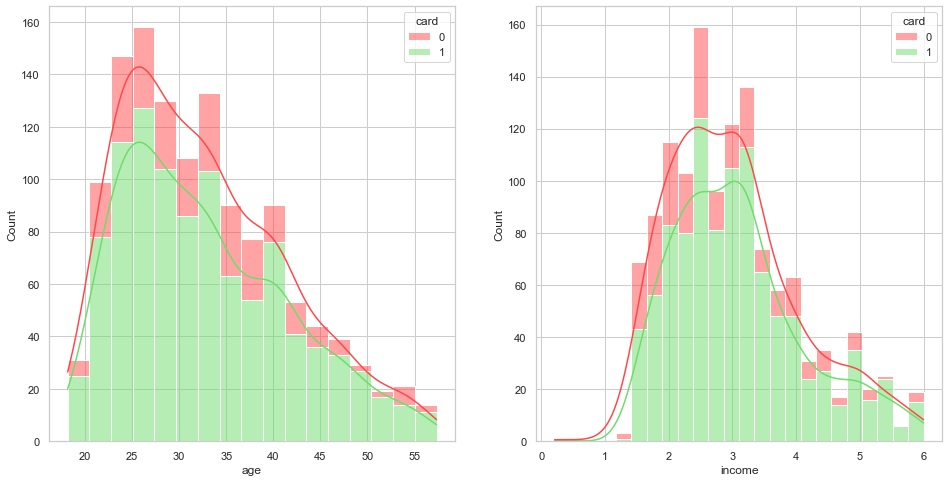

In [12]:
sns.set(rc={'figure.figsize':(16, 8)})
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2)
sns.histplot(data = credit_card, stat="count", multiple="stack", x = "age", hue="card", element="bars", palette = palette,
legend=True, kde = True, ax=axes[0])
sns.histplot(data = credit_card, stat="count", multiple="stack", x = "income", hue="card", element="bars", palette = palette,
legend=True, kde = True, ax=axes[1])

**Interpretation** <br>
The presented visualization shows the asymmetric right-hand age distribution of people applying for a loan. It can be observed that the largest number of loan applications came from a group of young people aged around 26 who are most likely in their professional careers and are considering buying some real estate. There are two groups where the number of applications is small. The first of them are very young people, around 18 years of age. The reason for such a state of affairs is, above all, the often undefined professional position and the unspecified plans for the future. On the other hand, there is a noticeable group of elderly people who most likely know their loan repayment options and base their existence on what they have earned in the past.

The second histogram is more symmetrical and is dedicated to the income of potential borrowers. Among the people interested in taking out a loan, people with an annual income of around $ 30,000 are dominant. The lowest number of loan applications was submitted by low earners and wealthy people. This is due to the fact that the first group is aware of their limitations in paying off the loan. Nevertheless, there is a sharp increase in interest in credit as earnings increase up to a point. On the other hand, people with significant amounts on the account do not often need to take a loan. Applications in this case are rarely rejected.

<AxesSubplot:xlabel='expenditure', ylabel='Count'>

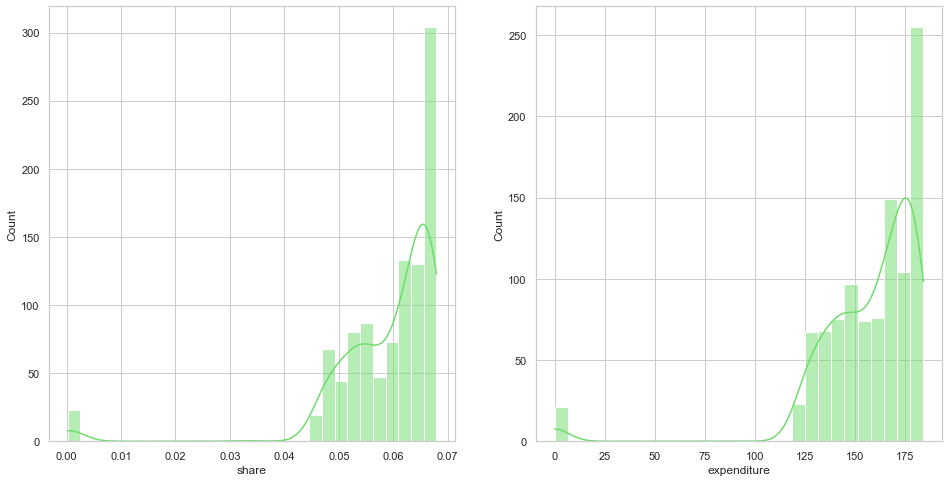

In [13]:
sns.set(rc={'figure.figsize':(16, 8)})
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2)
sns.histplot(data = credit_card[credit_card['card'] == 1], stat="count", x = "share", element="bars", color = '#6fdc6c',
kde = True, ax=axes[0])
sns.histplot(data = credit_card[credit_card['card'] == 1], stat="count", x = "expenditure", element="bars", color = '#6fdc6c',
kde = True, ax=axes[1])

**Interpretation** <br>
The charts here focus on the expenses and their share in the borrowers' income. They have a more informative function showing the consumer behavior of such people. They show that most credit holders seek to maximize their consumption.

<AxesSubplot:xlabel='active', ylabel='Count'>

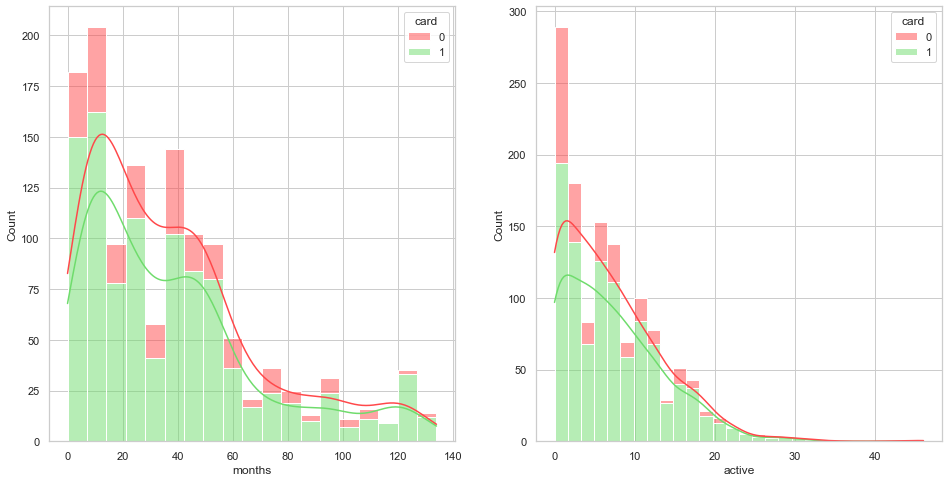

In [14]:
sns.set(rc={'figure.figsize':(16, 8)})
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2)
sns.histplot(data = credit_card, stat="count", multiple="stack", x = "months", hue="card", element="bars", palette = palette,
legend=True, kde = True, ax=axes[0])
sns.histplot(data = credit_card, stat="count", multiple="stack", x = "active", hue="card", element="bars", palette = palette,
legend=True, kde = True, ax=axes[1])

**Interpretation** <br>
The first histogram shows the distribution of the number of months from the moment potential borrowers live at their current address. What can be noticed is the advantage of people who have moved to a given place relatively recently. In addition, there is a visible decrease in the number of loan applications along with the length of stay in a given place. In this case, loans are more often approved, because a long period of residence may indicate a certain life stability of the person interested in the loan.

The second visualization shows how many accounts each group of people has. Most applicants have 1 active account. Along with the increase in the number of accounts, the number of loan applications and the number of negative decisions issued decrease. The financial institution most likely believes that such customers are more trusted or that it will be easier to get your money back.

<AxesSubplot:xlabel='owner', ylabel='count'>

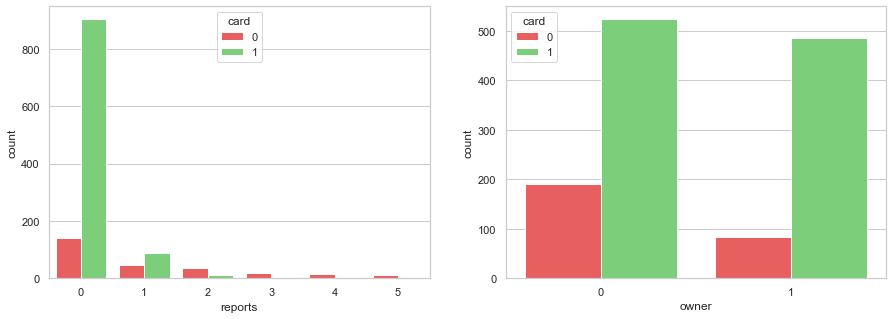

In [15]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.set_theme(style="whitegrid")
palette = {0:"#ff484a", 1:"#6fdc6c"}

fig, axes = plt.subplots(1, 2)

sns.countplot(data = credit_card, x = "reports", hue="card", palette = palette, ax=axes[0])
sns.countplot(data = credit_card, x = "owner", hue="card", palette = palette, ax=axes[1])

**Interpretation** <br>
The first visualization concerns the so-called 'derogatory reports'. These are negative reports about people applying for a loan, and they often lead to the rejection of applications sent by such entities. The reasons for their issuance are delays in repayment of loan installments. As the chart shows, the chances of getting a loan by people with at least 1 assigned report are very small. The discussed decrease takes place along with the increase in the number of such documents. People with 3 reports have virtually no chance of getting a loan.

The second chart shows how many people interested in a loan own or rent an apartment. In this case, the majority of people do not have their own premises. Moreover, in this group of people, loan applications are more often rejected. This can be interpreted as the bank's policy aimed at clients with an established financial situation.

<AxesSubplot:xlabel='selfemp', ylabel='count'>

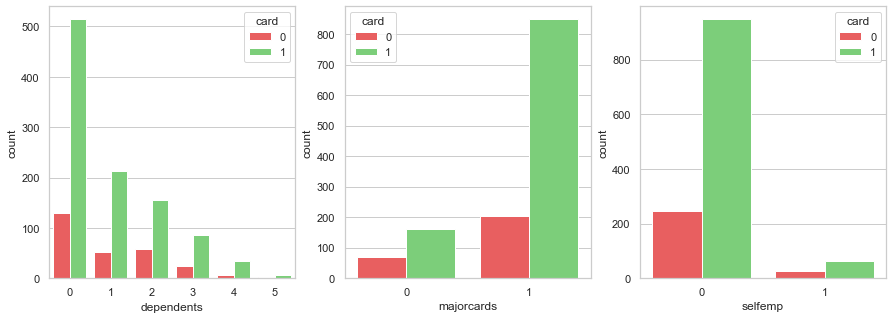

In [16]:
sns.set(rc={'figure.figsize':(15, 5)})
sns.set_theme(style="whitegrid")
palette = {0:"#ff484a", 1:"#6fdc6c"}

fig, axes = plt.subplots(1, 3)

sns.countplot(data = credit_card, x = "dependents", hue="card", palette = palette, ax=axes[0])
sns.countplot(data = credit_card, x = "majorcards", hue="card", palette = palette, ax=axes[1])
sns.countplot(data = credit_card, x = "selfemp", hue="card", palette = palette, ax=axes[2])

**Interpretation** <br>
The first graph shows the number of dependents of the applicant. The presented visualization shows that people living alone have the most applications, and at the same time a chance for a loan. As the number of dependents increases, the number of loan applications decreases. In each option under consideration, applications are approved more often than rejected.

The second visualization shows how many loan applicants have a primary credit card. It can be seen that cardholders are more likely to take a loan. In this case, the chances of getting a loan increase significantly.

The third chart shows how many of the respondents are self-employed. Visualization shows that there are more people working for someone than for themselves. Financial institutions want the client to need the services of a given institution. The best group in this case are people who are less independent.

### 2.4 Variable selection

<AxesSubplot:>

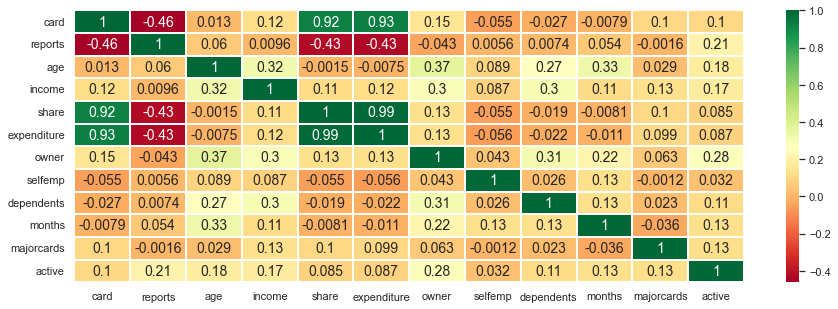

In [17]:
corr_matrix = credit_card.corr(method='pearson')
sns.heatmap(corr_matrix, annot=True,cmap='RdYlGn', linewidths=0.4, annot_kws={"size":14}) 

**Interpretation** <br>
Pearon's correlation matrix shows the relationships between the variables. Among the significant relationships, the largest observed correlations between the dependent variable and the explanatory variables should be distinguished. Looking at the values, it can be concluded that these are weak correlations. I am talking about the 'reports' and 'owner' variables. The correlation between these variables is very small, which makes it possible to use them in modeling. In order to mitigate the noise and to visualize the effects of the models' work, the two mentioned variables are taken into accoun

### 2.5 Data scaling and division of the data set into training and test sets
Many scoring methods are presented in the project. Most of them are models from the AI category that require scaled training and test sets. in order not to repeat this process, the required steps are carried out at this operating point each time. It is assumed that 30% of the dataset will be used for testing and 70% for model training. In addition, it should be noted that the explanatory variables are scaled.

In [18]:
x = credit_card.iloc[:, [1, 6]].values 
y = credit_card.iloc[:, 0].values  
   
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size = 0.3, random_state = 0)  
   
scaled_x = StandardScaler()    
x_train = scaled_x.fit_transform(x_train)    
x_test = scaled_x.transform(x_test)  

## 3. Selected methods of credit risk scoring

There are a large number of scoring models at the time this project was developed. The aim of this part of the project is to broaden the knowledge of credit risk scoring models. In addition to the selected existing methods from the classes, new methods worth knowing are implemented.

### 3.1 K-Nearest Neighbor (KNN)
** Description of the method ** <br>
KNN is a supervised machine learning algorithm. It assigns people with selected characteristics to positive or negative credit decisions. KNN is a non-parametric algorithm, i.e. one that has no assumptions about the form of the data used. This algorithm does not learn from a data set, but classifies people on a regular basis during its operation. <br>
The way it works can be described in the following steps:
1.selection of K number of neighbors;
2. computing the Euclidean distance between neighbors K;
3. selection of K people / neighbors according to the calculated distance;
4. counting people for positive and negative categories;
5. assigning new people to this category / decision with the greatest number of neighbors.

In the project, the value of K is determined by simulating the accuracy of the algorithm's work on a given range of the considered number of neighbors.

Text(0, 0.5, 'Accuracy')

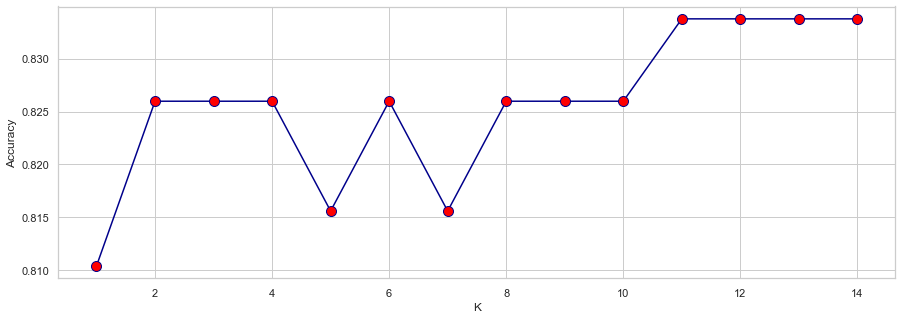

In [19]:
accuracy = []
for i in range(1, 15):
    neighbour = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    y_pred = neighbour.predict(x_test)
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    
plt.figure(figsize = (15, 5))
plt.plot(range(1, 15), accuracy, color = 'darkblue', marker='o',markerfacecolor='red', markersize = 10)
plt.xlabel('K')
plt.ylabel('Accuracy')

The graph shows that the highest accuracy of credit decision prediction occurs e.g. for K = 11.

In [20]:
knn = KNeighborsClassifier(n_neighbors = 11, metric = 'minkowski', p = 2)  
knn.fit(x_train, y_train)  
y_pred = knn.predict(x_test)  

**Visualizations** <br>
The visible effects of the algorithm's work are presented. How these visualizations look depends on the type of selected variables. The units whose credit decisions have been approved are marked in green, and those that have been rejected are marked in red. What is important is the position of people with positive and negative credit decisions among their neighbors. The fewer people with incorrectly assigned neighborhoods and the less differences between training and test visualizations, the greater the accuracy of the model's prediction.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


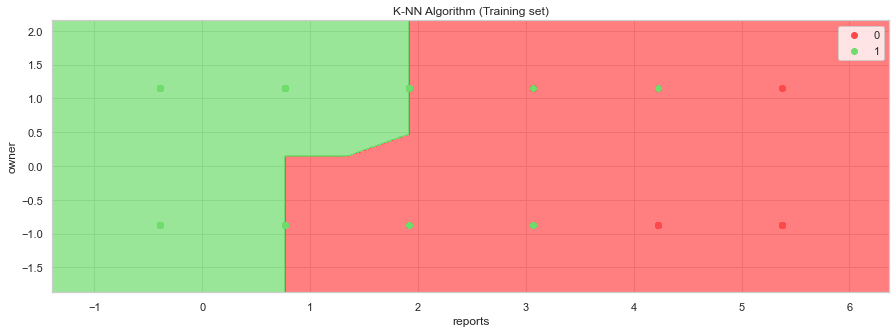

In [21]:
x_set, y_set = x_train, y_train 

x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  = 0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, knn.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  

plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  

for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
        c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j) 
    
plt.title('K-NN Algorithm (Training set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()   

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


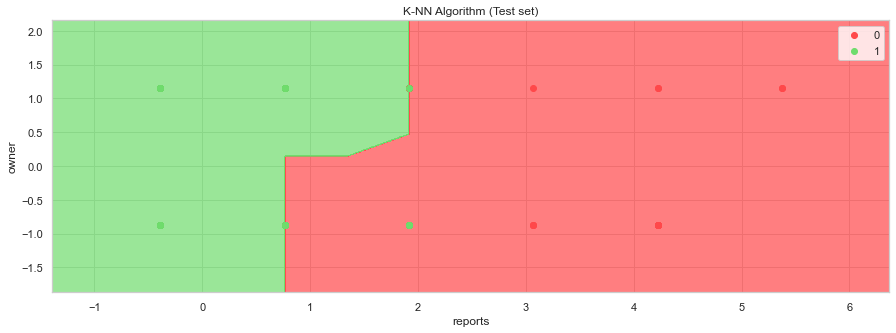

In [22]:
x_set, y_set = x_test, y_test  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step = 0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, knn.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  

plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  

for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
        c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  

plt.title('K-NN Algorithm (Test set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()   

At this point, the error matrix is calculated, but its presentation takes place in the next subsection.

In [23]:
cm_knn = confusion_matrix(y_test, y_pred, labels=knn.classes_)

### 3.2 Logistic Regression
**Description of the method** <br>
Logistic Regression is a supervised machine learning algorithm. In the project, it is a binomial regression used to predict the status of a credit decision based on selected variables. It is often presented as a sigmoidal probability function on the interval 0-1. Logistic regression has two assumptions: the dependent variables are categorical and the explanatory variables are not collinear. They are fulfilled in the project.

In [24]:
lr = LogisticRegression(random_state=0)  
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)  

**Visualizations**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


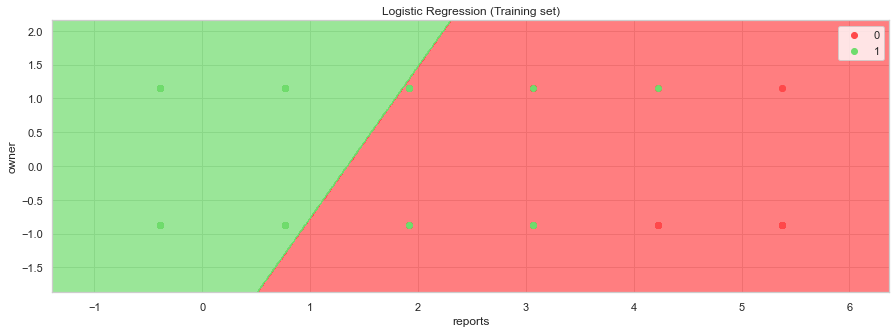

In [25]:
x_set, y_set = x_train, y_train  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step = 0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, lr.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max()) 

for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
        c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  
plt.title('Logistic Regression (Training set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()   

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


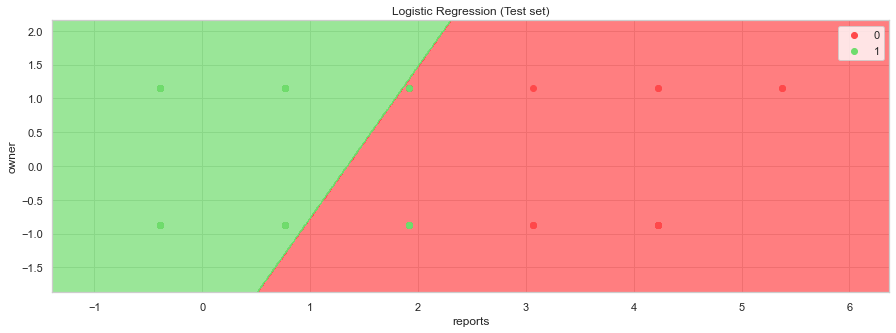

In [26]:
x_set, y_set = x_test, y_test  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step = 0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, lr.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
        c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  
plt.title('Logistic Regression (Test set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()   

In [27]:
cm_lr = confusion_matrix(y_test, y_pred, labels=lr.classes_)

### 3.3 Decision Tree Classification
**Description of the method** <br>
A decision tree is a supervised machine learning technique used in the project to classify credit strikers. The tree structure consists of:
1. root node - represents the entire data set;
2. leaf nodes - these represent the credit scores / decisions where the tree ends;
3. internal nodes - responsible for creating new bifurcations depending on the conditions in the node. At work, such nodes are selected explanatory variables;
4th branch - transition to the next nodes.

Information Gain method in the project determines which variables of the data set will become the root or other nodes. It consists in determining how much information profit is provided by each considered feature of the person applying for a loan. Depending on the size of these profits, the existing node is split and the tree is built in this way. Entropy maximization is desirable throughout the process. The final stage is the outgoing leaves, i.e. in this case positive or negative decisions about granting a loan.

In [28]:
dt = DecisionTreeClassifier(criterion='entropy', random_state = 0)  
dt.fit(x_train, y_train)   
y_pred = dt.predict(x_test)  

**Visualization**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


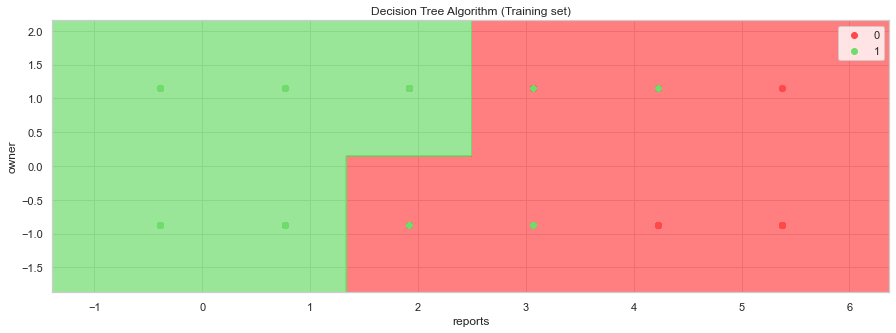

In [29]:
x_set, y_set = x_train, y_train  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  =0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, dt.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1],  
    c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j) 

plt.title('Decision Tree Algorithm (Training set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


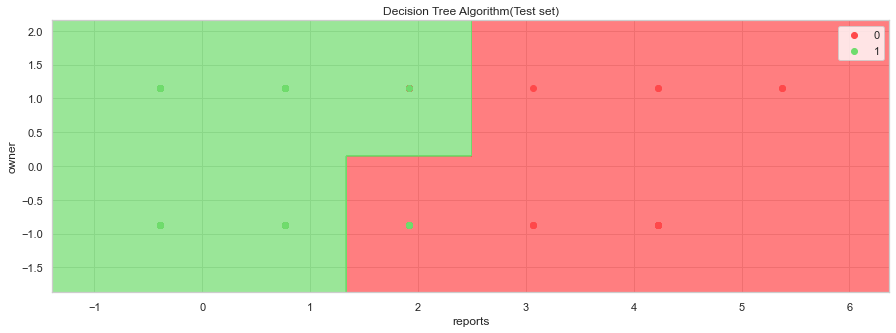

In [30]:
x_set, y_set = x_test, y_test  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step = 0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, dt.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  
plt.title('Decision Tree Algorithm(Test set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()  

In [31]:
cm_dt = confusion_matrix(y_test, y_pred, labels=dt.classes_)

### 3.4 Random Forest
**Description of the method** <br>
Random forest is a supervised machine learning algorithm. It is used in the project to classify loan applicants. Its assumptions are the accuracy of the data and the lack of correlation between the explanatory variables, which is fulfilled in the project. The operation of a random forest is based on repeatedly retrieving from decision trees with different mean subsets to improve the accuracy of the prediction of a dataset. Behind this description is a complex process:
1.selection of K points from the training dataset (in this case K = 11);
2. building decision trees related to these points;
3.1 The 1st and 2nd steps are repeated as many times as indicated by the set number.
4.New applicants from outside the sample are assigned to pass or fail / grade depending on which of them had a higher score before.

In [32]:
rf = RandomForestClassifier(n_estimators= 11, criterion="entropy")  
rf.fit(x_train, y_train)  
y_pred = rf.predict(x_test)  

**Visualizations**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


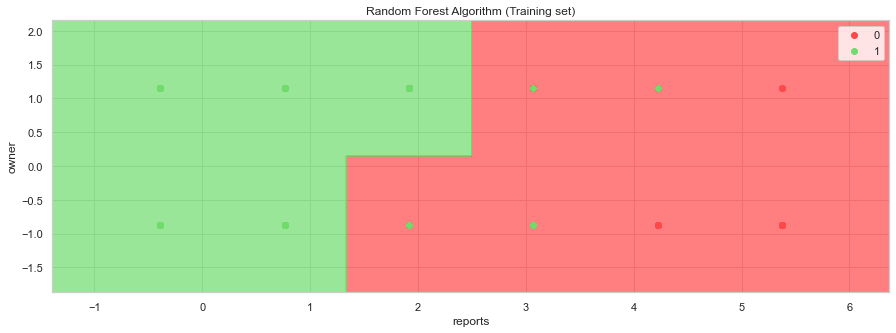

In [33]:
x_set, y_set = x_train, y_train  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step = 0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, rf.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  
plt.title('Random Forest Algorithm (Training set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend()  

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


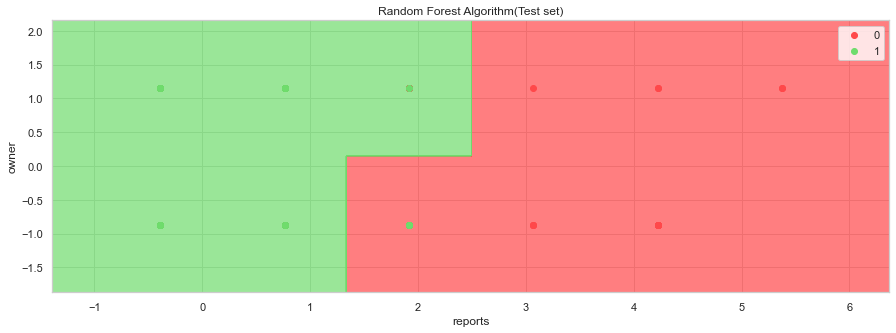

In [34]:
x_set, y_set = x_test, y_test  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  =0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, rf.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)    
plt.title('Random Forest Algorithm(Test set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend() 

In [35]:
cm_rf = confusion_matrix(y_test, y_pred, labels=rf.classes_)

### 3.5 Support Vector Machine (SVM)
**Description of the method** <br>
Support Vector Machine is a supervised machine learning algorithm. It is used in the project to classify credit increases. The goal of the SVM is to find a boundary that will allow class segregation. The literature distinguishes two types of SVM: linear and non-linear. When analyzing the project, it can be concluded that in this case a linear approach will be appropriate, because ultimately the data set is to be divided into two classes: positive and negative credit decisions.
The algorithm establishes the aforementioned limit by selecting support vectors to create a hyperplane. Being the best border it will allow you to classify people applying for a loan. Due to the fact that the variable being explained has a binomial distribution, the output of SVM will be a straight line.

In [36]:
svm = SVC(kernel = 'linear', random_state = 0)  
svm.fit(x_train, y_train)  
y_pred = svm.predict(x_test)  

**Visualizations**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


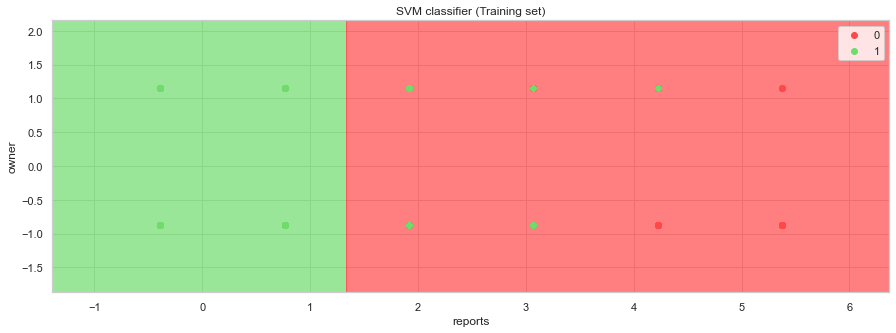

In [37]:
x_set, y_set = x_train, y_train  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  =0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, svm.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  
plt.title('SVM classifier (Training set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend() 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


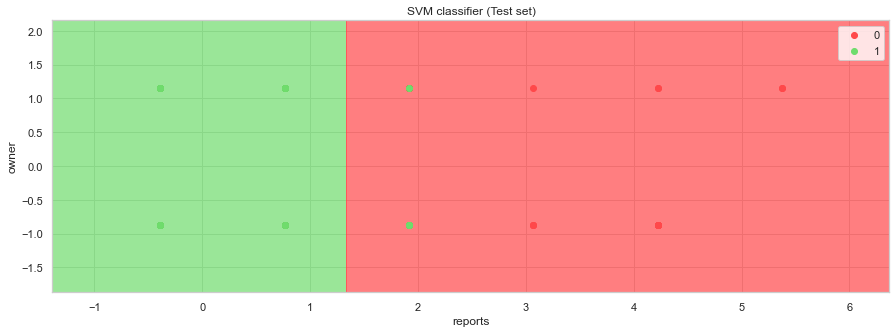

In [38]:
x_set, y_set = x_test, y_test  
x1, x6 = np.meshgrid(np.arange(start = x_set[:, 0].min() - 1, stop = x_set[:, 0].max() + 1, step  =0.01),  
np.arange(start = x_set[:, 1].min() - 1, stop = x_set[:, 1].max() + 1, step = 0.01))  
plt.contourf(x1, x6, svm.predict(np.array([x1.ravel(), x6.ravel()]).T).reshape(x1.shape),  
alpha = 0.7, cmap = ListedColormap(('#ff484a','#6fdc6c')))  
plt.xlim(x1.min(), x1.max())  
plt.ylim(x6.min(), x6.max())  
for i, j in enumerate(np.unique(y_set)):  
    plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c = ListedColormap(('#ff484a','#6fdc6c'))(i), label = j)  
plt.title('SVM classifier (Test set)')  
plt.xlabel('reports')  
plt.ylabel('owner')  
plt.legend() 

In [39]:
cm_svm = confusion_matrix(y_test, y_pred, labels=svm.classes_)

## 4. Evaluation of scoring methods
The fourth chapter focuses on the evaluation of the effects of pract scoring methods. For this purpose, an error matrix is used, thanks to which it is possible to know to what extent the model forecasts are effective.

### 4.1 K-Nearest Neighbor (KNN)

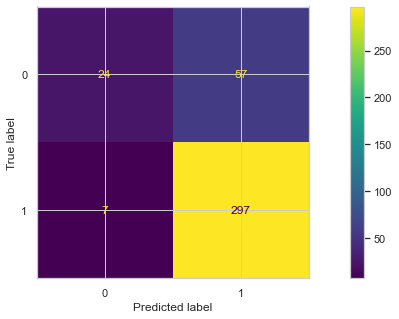

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=knn.classes_)
disp.plot()

In [41]:
TP = 24
TN = 297
FP = 57
FN = 7
ACC = (TP + TN) / (TP + TN + FP + FN)
print(ACC)
TPR = TP / (TP + FN)
print(TPR)
SP = TN / (FP + TN)
print(SP)

0.8337662337662337
0.7741935483870968
0.8389830508474576


**Interpretation** <br>
1. The Accuracy Factor (ACC) shows that 83.38% of the set has been correctly assigned.
2. Sensitivity (TPR) informs that the class of positive credit decisions was covered in 77.42%.
3. Specificity (SP) indicates that 83.90% of the negative credit decision class has been covered.

### 4.2 Logistic Regression

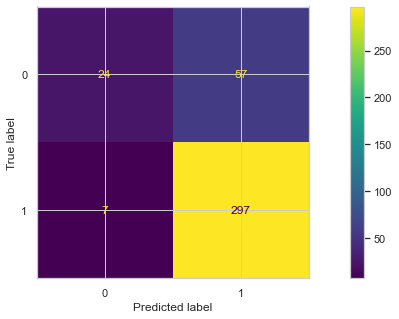

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr.classes_)
disp.plot()

In [43]:
TP = 24
TN = 297
FP = 57
FN = 7
ACC = (TP + TN) / (TP + TN + FP + FN)
print(ACC)
TPR = TP / (TP + FN)
print(TPR)
SP = TN / (FP + TN)
print(SP)

0.8337662337662337
0.7741935483870968
0.8389830508474576


**Interpretation** <br>
1. The Accuracy Factor (ACC) shows that 83.38% of the set has been correctly assigned.
2. Sensitivity (TPR) informs that the class of positive credit decisions was covered in 77.42%.
3. Specificity (SP) indicates that 83.90% of the negative credit decision class has been covered.

### 4.3 Decission Tree

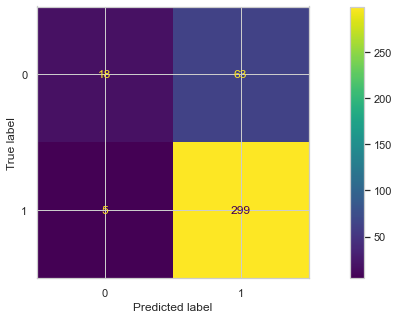

In [44]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm_dt, display_labels = dt.classes_)
disp.plot()

In [45]:
TP = 18
TN = 299
FP = 63
FN = 5
ACC = (TP + TN) / (TP + TN + FP + FN)
print(ACC)
TPR = TP / (TP + FN)
print(TPR)
SP = TN / (FP + TN)
print(SP)

0.8233766233766234
0.782608695652174
0.8259668508287292


**Interpretation** <br>
1. The Accuracy Factor (ACC) shows that 82.34% of the set has been correctly assigned.
2. Sensitivity (TPR) informs that the class of positive credit decisions was covered in 78.26%.
3. Specificity (SP) indicates that 82.60% of the negative credit decision class has been covered.

### 4.4 Random Forest

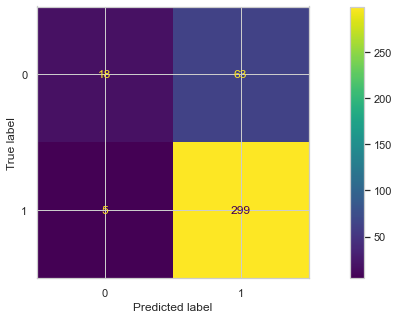

In [46]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_)
disp.plot()

In [47]:
TP = 16
TN = 299
FP = 65
FN = 5
ACC = (TP + TN) / (TP + TN + FP + FN)
print(ACC)
TPR = TP / (TP + FN)
print(TPR)
SP = TN / (FP + TN)
print(SP)

0.8181818181818182
0.7619047619047619
0.8214285714285714


**Interpretation** <br>
1. The Accuracy Factor (ACC) shows that 81.82% of the set has been correctly assigned.
2. Sensitivity (TPR) informs that 76.20% of the class of positive credit decisions was covered.
3. Specificity (SP) indicates that 82.14% of the negative credit decision class has been covered.

### 4.5 Support Vector Machine (SVM)

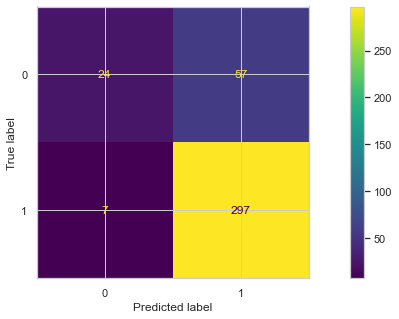

In [48]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm.classes_)
disp.plot()

In [49]:
TP = 24
TN = 297
FP = 57
FN = 7
ACC = (TP + TN) / (TP + TN + FP + FN)
print(ACC)
TPR = TP / (TP + FN)
print(TPR)
SP = TN / (FP + TN)
print(SP)

0.8337662337662337
0.7741935483870968
0.8389830508474576


**Interpretation** <br>
1. The Accuracy Factor (ACC) shows that 83.38% of the set has been correctly assigned.
2. Sensitivity (TPR) informs that the class of positive credit decisions was covered in 77.42%.
3. Specificity (SP) indicates that 83.90% of the negative credit decision class has been covered.

### 4.6 Method comparison

|Method||Accuracy||Sensivity||Specifity|
|------||--------||---------||---------|
|KNN||0.8338||0.7742||0.8390||
|Logistic Regression||0.8338||0.7742||0.8390|
|Decission Tree|| 0.8234||0.7826||0.8260|
|Random Forest||0.8182||0.7620||0.8214|
|SVM||0.8338||0.7742||0.8390|

**Interpretacja** <br>
W przypadku tego projektu nalezy bardziej można się wyniknąć z wynikówmi wynikami i metodami uzyskiwania punktów kredytowych. Gdy jedna z nich na drugie maleje. W miejscu, w którym można znaleźć, że można znaleźć sposób, aby znaleźć się na miejscu.

## 5. Summary

W trackcie tego projektu prezentno istotne teoretyczne aspekty scoringu kredytowego. W ramch praktykj części danych. oraz przeanalizowano dane z danych. To co najistotniejsze badanie przy wyborze metody oceniania, a ich działanie na działanie oceny oraz zestawieniu.